# Assignment 4

## Setup

In [2]:
! pip3 install -r requirements.txt

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_wine
from ucimlrepo import fetch_ucirepo 
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold
import time
import json
import os

In [ ]:
# Loading data

# Iris dataset
X, y = load_iris(return_X_y=True, as_frame=True)
iris_df = X.copy()
iris_df['target'] = y
print(iris_df.shape)
display(iris_df.head())



(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


(178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(70000, 785)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [ ]:
# Wine dataset
X, y = load_wine(return_X_y=True, as_frame=True)
wine_df = X.copy()
wine_df['target'] = y
print(wine_df.shape)
display(wine_df.head())


In [86]:

# Adult income dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features 
y = adult.data.targets 
adult_df = X.copy()
adult_df['target'] = y
print(adult_df.shape)
display(adult_df.head())



(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target
mnist_df = X.copy()
mnist_df['target'] = y
print(mnist_df.shape)
display(mnist_df.head())

## Pre-processing

In [90]:
# Pre-processing Iris dataset

iris_features = iris_df.drop('target', axis=1)
iris_target = iris_df['target']

# Split before scaling to avoid data leakage
# X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
#     iris_features, iris_target, test_size=0.2, random_state=42
# )

iris_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit only on training data
# X_train_iris_scaled = iris_pipeline.fit_transform(X_train_iris)
# X_test_iris_scaled = iris_pipeline.transform(X_test_iris)

X_iris_scaled = iris_pipeline.fit_transform(iris_features)  # full scaled features
y_iris = iris_target.values  # full target

In [81]:
# Pre-processing Wine dataset

wine_features = wine_df.drop('target', axis=1)
wine_target = wine_df['target']

# # Split before scaling
# X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
#     wine_features, wine_target, test_size=0.2, random_state=42
# )

wine_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# # Fit only on training data
# X_train_wine_scaled = wine_pipeline.fit_transform(X_train_wine)
# X_test_wine_scaled = wine_pipeline.transform(X_test_wine)

X_wine_scaled = wine_pipeline.fit_transform(wine_features)
y_wine = wine_target.values

In [87]:
# Pre process Adult Income dataset

# After cleaning and encoding target
adult_df = adult_df.replace('?', np.nan).dropna()
adult_df['target'] = adult_df['target'].astype(str).str.strip().str.replace('.', '', regex=False)
adult_df['target'] = adult_df['target'].map({'<=50K': 0, '>50K': 1})

# Drop rows where target could not be mapped (i.e., is NaN)
adult_df = adult_df.dropna(subset=['target'])

# Optional: sample for speed
adult_df_sampled = adult_df.sample(n=10000, random_state=42)

# Prepare features and target for CV
adult_features = adult_df_sampled.drop('target', axis=1)
adult_target = adult_df_sampled['target'].values

# Identify columns
categorical_cols = adult_features.select_dtypes(include=['object', 'category']).columns
numerical_cols = adult_features.select_dtypes(include=['number']).columns

adult_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit and transform on the full sampled data
X_adult_processed = adult_preprocessor.fit_transform(adult_features)

In [ ]:
# Pre-process MNIST dataset

mnist_features = mnist_df.drop('target', axis=1)
mnist_target = mnist_df['target'].astype(int)

# Split before scaling
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = train_test_split(
    mnist_features, mnist_target, test_size=0.2, random_state=42, stratify=mnist_target
)

mnist_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit only on training data
X_train_mnist_scaled = mnist_pipeline.fit_transform(X_train_mnist)
X_test_mnist_scaled = mnist_pipeline.transform(X_test_mnist)

## Experiment 1

Vary tree depth: 

- Keep number of decision trees in random forest fixed.
- Keep number of descriptive features to split on fixed.
- Keep bag size fixed.

Results: Accuracy vs tree depth

In [79]:
def run_tree_depth_experiment(
    X, y,
    depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, None],
    n_estimators=100,
    max_features='sqrt',
    random_state=42,
    results_dir='.',
    dataset_name='dataset',
    cv=5
):
    """
    Runs an experiment varying max tree depth for a Random Forest using cross-validation.
    Tracks mean and std of metrics over folds. Saves metrics to a JSON file.
    """
    metrics = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for depth in depths:
        fold_accuracies = []
        fold_f1s = []
        fold_stddevs = []
        fold_cms = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=depth,
                max_features=max_features,
                random_state=random_state,
                class_weight='balanced'
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred)
            if hasattr(clf, "predict_proba"):
                proba = clf.predict_proba(X_test)
                std_dev = float(np.std(proba))
            else:
                std_dev = None
            fold_accuracies.append(acc)
            fold_f1s.append(f1)
            fold_stddevs.append(std_dev)
            fold_cms.append(cm.tolist())
        metrics.append({
            'max_depth': depth if depth is not None else 'None',
            'accuracy_mean': np.mean(fold_accuracies),
            'accuracy_std': np.std(fold_accuracies),
            'f1_mean': np.mean(fold_f1s),
            'f1_std': np.std(fold_f1s),
            'std_dev_mean': np.mean([v for v in fold_stddevs if v is not None]),
            'std_dev_std': np.std([v for v in fold_stddevs if v is not None]),
            'confusion_matrices': fold_cms
        })
        print(f"Depth: {depth}, Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}, "
              f"F1: {np.mean(fold_f1s):.3f} ± {np.std(fold_f1s):.3f}")
    # Save metrics to file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"{results_dir}/rf_tree_depth_cv_metrics__{dataset_name}__{timestamp}.json"
    os.makedirs(results_dir, exist_ok=True)
    with open(filename, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to {filename}")

    return metrics, filename

In [83]:
def plot_depth_vs_accuracy(filename):    
    # Load metrics from file
    with open(filename, 'r') as f:
        metrics = json.load(f)

    # Extract tree depths and mean/std accuracies
    depths = [m['max_depth'] if m['max_depth'] != 'None' else None for m in metrics]
    accuracies_mean = [m['accuracy_mean'] for m in metrics]
    accuracies_std = [m['accuracy_std'] for m in metrics]

    # Convert 'None' to a label for plotting
    depth_labels = [str(d) if d is not None else 'None' for d in depths]

    plt.figure(figsize=(8, 5))
    plt.errorbar(depth_labels, accuracies_mean, yerr=accuracies_std, marker='o', capsize=4)
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Accuracy (Mean ± Std, CV)')
    plt.title('Accuracy vs Tree Depth (Cross-Validation)')
    plt.grid(True)
    plt.show()

Depth: 1, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 2, Accuracy: 0.953 ± 0.034, F1: 0.953 ± 0.034
Depth: 3, Accuracy: 0.967 ± 0.030, F1: 0.967 ± 0.030
Depth: 4, Accuracy: 0.960 ± 0.039, F1: 0.960 ± 0.039
Depth: 5, Accuracy: 0.953 ± 0.034, F1: 0.953 ± 0.034
Depth: 6, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 7, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 8, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 9, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 10, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 15, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 20, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 25, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: 30, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Depth: None, Accuracy: 0.947 ± 0.027, F1: 0.946 ± 0.027
Metrics saved to experiment_1/rf_tree_depth_cv_metrics__iris__20251018-175006.json


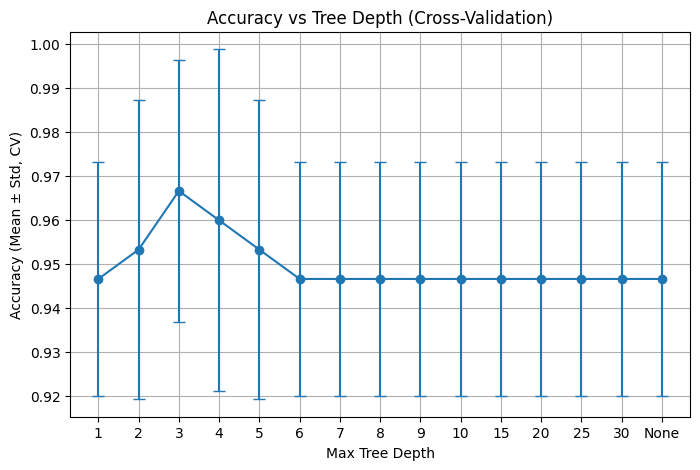

In [91]:
# Iris experiment
iris_metrics, iris_filename = run_tree_depth_experiment(
    X_iris_scaled, y_iris,
    results_dir='experiment_1',
    dataset_name='iris'
)

plot_depth_vs_accuracy(iris_filename)

Depth: 1, Accuracy: 0.927 ± 0.014, F1: 0.926 ± 0.013
Depth: 2, Accuracy: 0.978 ± 0.021, F1: 0.977 ± 0.021
Depth: 3, Accuracy: 0.983 ± 0.014, F1: 0.983 ± 0.014
Depth: 4, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 5, Accuracy: 0.983 ± 0.023, F1: 0.983 ± 0.023
Depth: 6, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 7, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 8, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 9, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 10, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 15, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 20, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 25, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: 30, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Depth: None, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Metrics saved to experiment_1/rf_tree_depth_cv_metrics__wine__20251018-174407.json


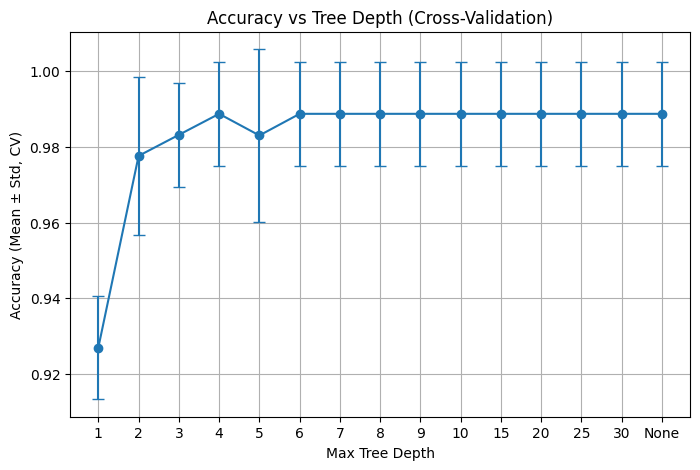

In [84]:
# Wine experiment
wine_metrics, wine_filename = run_tree_depth_experiment(
    X_wine_scaled, y_wine,
    results_dir='experiment_1',
    dataset_name='wine'
)

plot_depth_vs_accuracy(wine_filename)

Depth: 1, Accuracy: 0.738 ± 0.007, F1: 0.755 ± 0.006
Depth: 2, Accuracy: 0.738 ± 0.006, F1: 0.755 ± 0.006
Depth: 3, Accuracy: 0.739 ± 0.007, F1: 0.756 ± 0.006
Depth: 4, Accuracy: 0.745 ± 0.007, F1: 0.761 ± 0.006
Depth: 5, Accuracy: 0.755 ± 0.007, F1: 0.770 ± 0.006
Depth: 6, Accuracy: 0.768 ± 0.008, F1: 0.783 ± 0.007
Depth: 7, Accuracy: 0.777 ± 0.010, F1: 0.791 ± 0.009
Depth: 8, Accuracy: 0.786 ± 0.011, F1: 0.799 ± 0.010
Depth: 9, Accuracy: 0.796 ± 0.009, F1: 0.807 ± 0.008
Depth: 10, Accuracy: 0.802 ± 0.006, F1: 0.813 ± 0.005
Depth: 15, Accuracy: 0.820 ± 0.004, F1: 0.828 ± 0.004
Depth: 20, Accuracy: 0.837 ± 0.004, F1: 0.841 ± 0.004
Depth: 25, Accuracy: 0.843 ± 0.004, F1: 0.845 ± 0.004
Depth: 30, Accuracy: 0.847 ± 0.005, F1: 0.846 ± 0.005
Depth: None, Accuracy: 0.848 ± 0.005, F1: 0.844 ± 0.004
Metrics saved to experiment_1/rf_tree_depth_cv_metrics__adult_income__20251018-174651.json


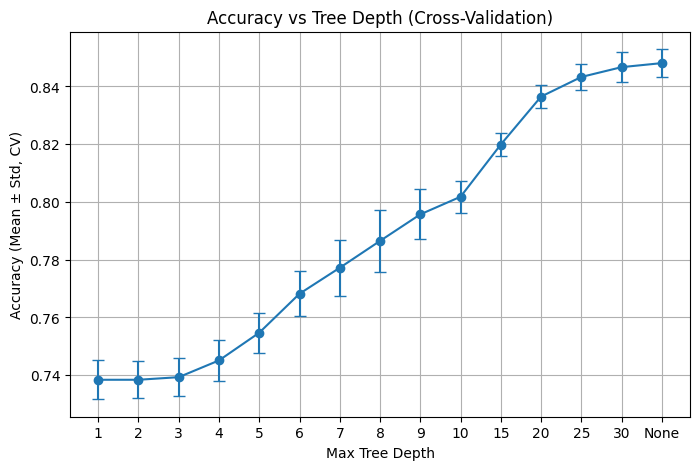

In [88]:
# Adult Income experiment
adult_metrics, adult_filename = run_tree_depth_experiment(
    X_adult_processed, adult_target,
    results_dir='experiment_1',
    dataset_name='adult_income'
)

plot_depth_vs_accuracy(adult_filename)

## Experiment 2
Relationship between tree depth and number of trees in random forest:

- Fix number of descriptive features to split on fixed.
- Fix bag size.

Cross compare tree depths and number of trees

Results: Heatmap or line plot

In [95]:
def visualize_depth_vs_n_estimators_results(filename):
    """
    Visualizes results from run_depth_vs_n_estimators_experiment.
    Produces a heatmap (accuracy), line plot (accuracy vs n_estimators for each depth),
    and confusion matrix for the best model.
    """
    with open(filename, 'r') as f:
        metrics = json.load(f)

    import pandas as pd
    df = pd.DataFrame(metrics)
    df['max_depth'] = df['max_depth'].replace('None', None)
    df['max_depth'] = df['max_depth'].apply(lambda x: int(x) if x is not None else None)

    # Use mean accuracy from CV
    heatmap_data = df.pivot(index='max_depth', columns='n_estimators', values='accuracy_mean')
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Accuracy Heatmap: Tree Depth vs Number of Trees (Mean CV)")
    plt.xlabel("Number of Trees")
    plt.ylabel("Max Tree Depth")
    plt.show()

    # Line plot: accuracy vs n_estimators for each depth
    plt.figure(figsize=(8, 5))
    for depth in sorted(df['max_depth'].dropna().unique()):
        subset = df[df['max_depth'] == depth]
        plt.plot(subset['n_estimators'], subset['accuracy_mean'], marker='o', label=f'Depth {depth}')
    if None in df['max_depth'].values:
        subset = df[df['max_depth'].isnull()]
        plt.plot(subset['n_estimators'], subset['accuracy_mean'], marker='o', label='Depth None')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy (Mean CV)')
    plt.title('Accuracy vs Number of Trees for Each Depth (Mean CV)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion matrix for best model (highest mean accuracy)
    best = max(metrics, key=lambda m: m['accuracy_mean'])
    # Use the first confusion matrix from CV folds
    cm = np.array(best['confusion_matrices'][0])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix (Best Model)\nDepth: {best['max_depth']}, Trees: {best['n_estimators']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [94]:
def run_depth_vs_n_estimators_experiment(
    X, y,
    depths=[1, 2, 5, 10, 15, 20, 25, 30, 40, 50, None],
    n_estimators_list=[10, 25, 50, 75, 100, 150, 200, 300, 400, 500],
    max_features='sqrt',
    random_state=42,
    results_dir='experiment_2',
    dataset_name='dataset',
    cv=5
):
    """
    Explores the relationship between tree depth and number of trees in a Random Forest using cross-validation.
    Tracks mean and std of metrics over folds. Saves metrics to a JSON file.
    """
    metrics = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for depth in depths:
        for n_estimators in n_estimators_list:
            fold_accuracies = []
            fold_f1s = []
            fold_stddevs = []
            fold_cms = []
            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                clf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=depth,
                    max_features=max_features,
                    random_state=random_state,
                    class_weight='balanced'
                )
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                cm = confusion_matrix(y_test, y_pred)
                if hasattr(clf, "predict_proba"):
                    proba = clf.predict_proba(X_test)
                    std_dev = float(np.std(proba))
                else:
                    std_dev = None
                fold_accuracies.append(acc)
                fold_f1s.append(f1)
                fold_stddevs.append(std_dev)
                fold_cms.append(cm.tolist())
            metrics.append({
                'max_depth': depth if depth is not None else 'None',
                'n_estimators': n_estimators,
                'accuracy_mean': np.mean(fold_accuracies),
                'accuracy_std': np.std(fold_accuracies),
                'f1_mean': np.mean(fold_f1s),
                'f1_std': np.std(fold_f1s),
                'std_dev_mean': np.mean([v for v in fold_stddevs if v is not None]),
                'std_dev_std': np.std([v for v in fold_stddevs if v is not None]),
                'confusion_matrices': fold_cms
            })
            print(f"Depth: {depth}, Trees: {n_estimators}, Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}, F1: {np.mean(fold_f1s):.3f} ± {np.std(fold_f1s):.3f}")
    # Save metrics to file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"{results_dir}/rf_depth_vs_n_estimators_cv__{dataset_name}__{timestamp}.json"
    os.makedirs(results_dir, exist_ok=True)
    with open(filename, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to {filename}")

    return metrics, filename

Depth: 1, Trees: 10, Accuracy: 0.882 ± 0.022, F1: 0.880 ± 0.021
Depth: 1, Trees: 25, Accuracy: 0.921 ± 0.028, F1: 0.920 ± 0.028
Depth: 1, Trees: 50, Accuracy: 0.921 ± 0.028, F1: 0.920 ± 0.028
Depth: 1, Trees: 75, Accuracy: 0.933 ± 0.014, F1: 0.932 ± 0.014
Depth: 1, Trees: 100, Accuracy: 0.927 ± 0.014, F1: 0.926 ± 0.013
Depth: 1, Trees: 150, Accuracy: 0.938 ± 0.021, F1: 0.938 ± 0.021
Depth: 1, Trees: 200, Accuracy: 0.933 ± 0.014, F1: 0.932 ± 0.014
Depth: 1, Trees: 300, Accuracy: 0.927 ± 0.028, F1: 0.926 ± 0.029
Depth: 1, Trees: 400, Accuracy: 0.927 ± 0.022, F1: 0.926 ± 0.023
Depth: 1, Trees: 500, Accuracy: 0.933 ± 0.028, F1: 0.932 ± 0.030
Depth: 2, Trees: 10, Accuracy: 0.961 ± 0.028, F1: 0.960 ± 0.029
Depth: 2, Trees: 25, Accuracy: 0.972 ± 0.025, F1: 0.972 ± 0.026
Depth: 2, Trees: 50, Accuracy: 0.978 ± 0.021, F1: 0.977 ± 0.021
Depth: 2, Trees: 75, Accuracy: 0.978 ± 0.021, F1: 0.977 ± 0.021
Depth: 2, Trees: 100, Accuracy: 0.978 ± 0.021, F1: 0.977 ± 0.021
Depth: 2, Trees: 150, Accuracy: 0

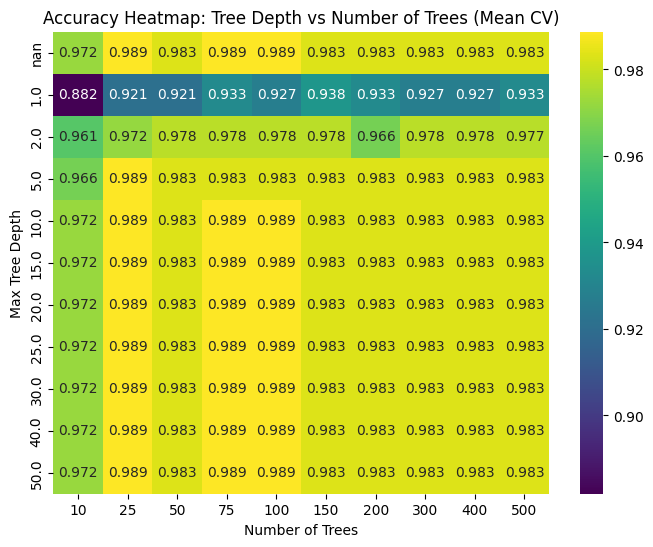

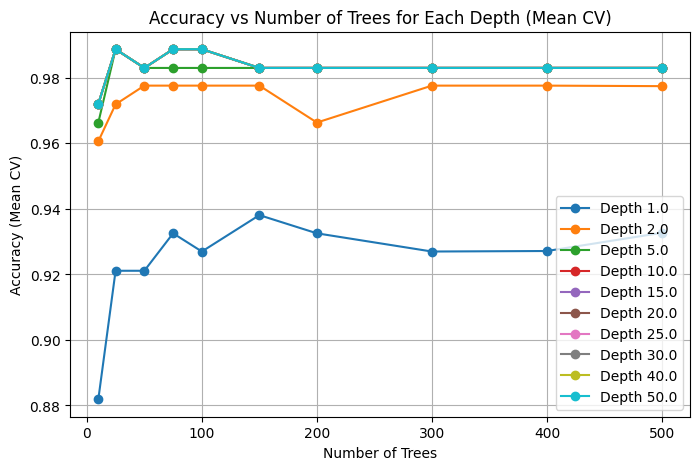

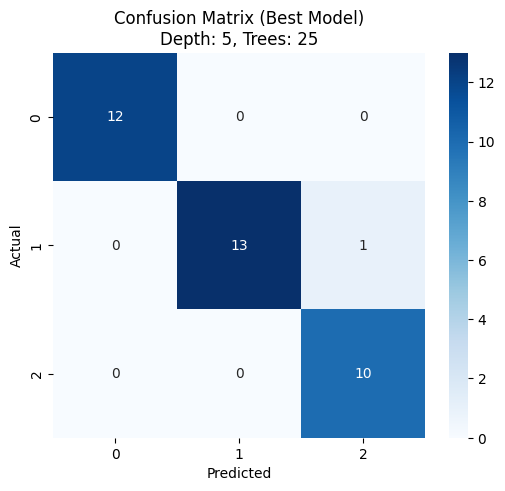

In [96]:
# Wine experiment
wine_depth_nest_metrics, wine_depth_nest_filename = run_depth_vs_n_estimators_experiment(
    X_wine_scaled, y_wine,
    dataset_name='wine'
)

visualize_depth_vs_n_estimators_results(wine_depth_nest_filename)

Depth: 1, Trees: 10, Accuracy: 0.725 ± 0.016, F1: 0.743 ± 0.015
Depth: 1, Trees: 25, Accuracy: 0.740 ± 0.008, F1: 0.756 ± 0.007
Depth: 1, Trees: 50, Accuracy: 0.739 ± 0.005, F1: 0.755 ± 0.004
Depth: 1, Trees: 75, Accuracy: 0.737 ± 0.008, F1: 0.753 ± 0.008
Depth: 1, Trees: 100, Accuracy: 0.738 ± 0.007, F1: 0.755 ± 0.006
Depth: 1, Trees: 150, Accuracy: 0.734 ± 0.004, F1: 0.751 ± 0.004
Depth: 1, Trees: 200, Accuracy: 0.732 ± 0.003, F1: 0.748 ± 0.003
Depth: 1, Trees: 300, Accuracy: 0.730 ± 0.005, F1: 0.747 ± 0.004
Depth: 1, Trees: 400, Accuracy: 0.730 ± 0.005, F1: 0.747 ± 0.004
Depth: 1, Trees: 500, Accuracy: 0.730 ± 0.004, F1: 0.747 ± 0.004
Depth: 2, Trees: 10, Accuracy: 0.744 ± 0.011, F1: 0.760 ± 0.010
Depth: 2, Trees: 25, Accuracy: 0.748 ± 0.009, F1: 0.764 ± 0.008
Depth: 2, Trees: 50, Accuracy: 0.745 ± 0.009, F1: 0.760 ± 0.008
Depth: 2, Trees: 75, Accuracy: 0.741 ± 0.009, F1: 0.757 ± 0.008
Depth: 2, Trees: 100, Accuracy: 0.738 ± 0.006, F1: 0.755 ± 0.006
Depth: 2, Trees: 150, Accuracy: 0

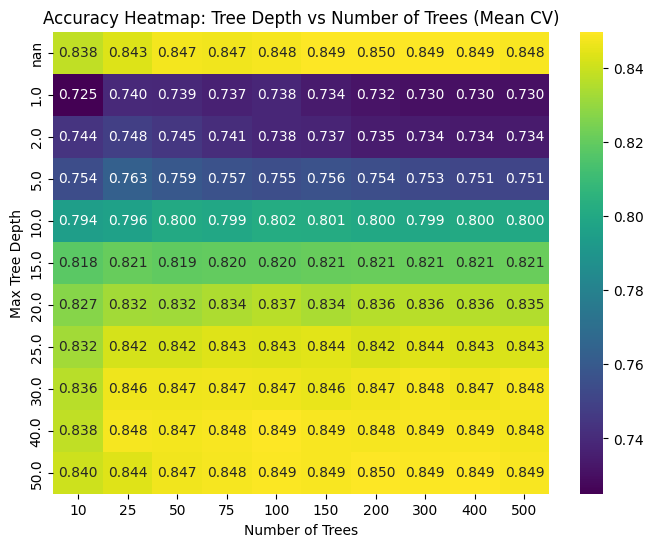

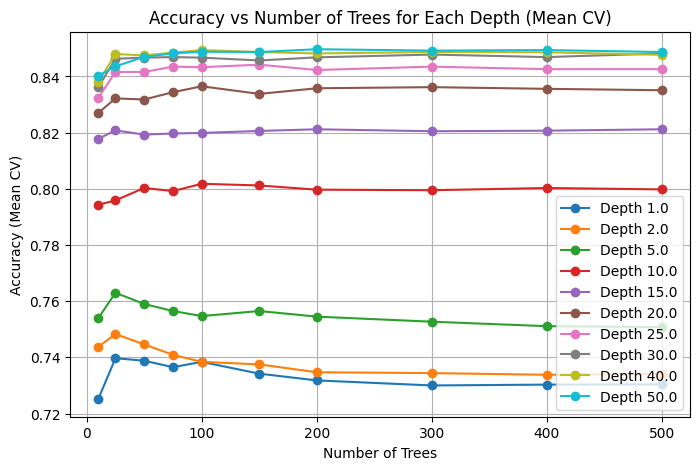

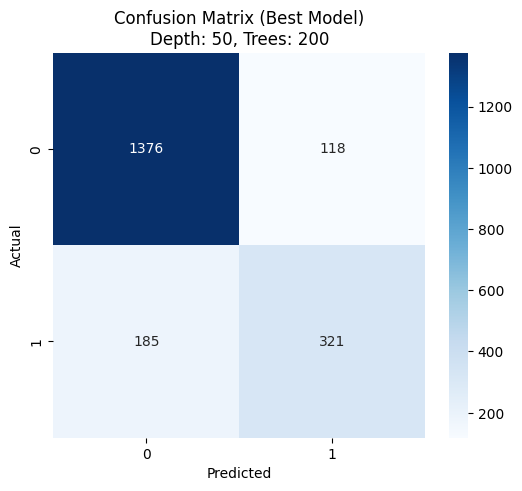

In [97]:
# Adult Income experiment
adult_adult_metrics, adult_filename = run_depth_vs_n_estimators_experiment(
    X_adult_processed, adult_target,
    dataset_name='adult_income'
)

visualize_depth_vs_n_estimators_results(adult_filename)

## Experiment 3

Vary number of features to split on:

- Fix other parameters (max_depth = prev_best ??)

Results: accuracy vs number of features 

In [98]:
def plot_max_features_vs_accuracy(filename):
    # Load metrics from file
    with open(filename, 'r') as f:
        metrics = json.load(f)

    # Extract max_features and mean accuracies from CV
    max_features = [m['max_features'] for m in metrics]
    accuracies_mean = [m['accuracy_mean'] for m in metrics]
    accuracies_std = [m['accuracy_std'] for m in metrics]

    plt.figure(figsize=(8, 5))
    plt.errorbar(max_features, accuracies_mean, yerr=accuracies_std, marker='o', capsize=4)
    plt.xlabel('Max Features to Split On')
    plt.ylabel('Accuracy (Mean ± Std, CV)')
    plt.title('Accuracy vs Number of Features to Split On (Cross-Validation)')
    plt.grid(True)
    plt.show()

In [99]:
def run_max_features_experiment(
    X, y,
    max_features_list=['sqrt', 'log2', None, 0.25, 0.5, 1, 5, 10, 20, 50, 100],
    n_estimators=100,
    max_depth=None,
    random_state=42,
    results_dir='experiment_3',
    dataset_name='dataset',
    cv=5
):
    """
    Runs an experiment varying max_features for a Random Forest using cross-validation.
    Saves metrics to a JSON file with a timestamp.
    Returns a list of metrics for plotting.
    """
    metrics = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for max_features in max_features_list:
        fold_accuracies = []
        fold_f1s = []
        fold_stddevs = []
        fold_cms = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                max_features=max_features,
                random_state=random_state,
                class_weight='balanced'
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred)
            if hasattr(clf, "predict_proba"):
                proba = clf.predict_proba(X_test)
                std_dev = float(np.std(proba))
            else:
                std_dev = None
            fold_accuracies.append(acc)
            fold_f1s.append(f1)
            fold_stddevs.append(std_dev)
            fold_cms.append(cm.tolist())
        metrics.append({
            'max_features': str(max_features),
            'accuracy_mean': np.mean(fold_accuracies),
            'accuracy_std': np.std(fold_accuracies),
            'f1_mean': np.mean(fold_f1s),
            'f1_std': np.std(fold_f1s),
            'std_dev_mean': np.mean([v for v in fold_stddevs if v is not None]),
            'std_dev_std': np.std([v for v in fold_stddevs if v is not None]),
            'confusion_matrices': fold_cms
        })
        print(f"Max Features: {max_features}, Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}, F1: {np.mean(fold_f1s):.3f} ± {np.std(fold_f1s):.3f}")
    # Save metrics to file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"{results_dir}/rf_max_features_cv_metrics__{dataset_name}__{timestamp}.json"
    os.makedirs(results_dir, exist_ok=True)
    with open(filename, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to {filename}")

    return metrics, filename

Max Features: sqrt, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Max Features: log2, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Max Features: None, Accuracy: 0.960 ± 0.039, F1: 0.960 ± 0.039
Max Features: 0.25, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Max Features: 0.5, Accuracy: 0.977 ± 0.021, F1: 0.978 ± 0.021
Max Features: 1, Accuracy: 0.989 ± 0.014, F1: 0.989 ± 0.014
Max Features: 5, Accuracy: 0.977 ± 0.033, F1: 0.977 ± 0.033
Max Features: 10, Accuracy: 0.955 ± 0.039, F1: 0.954 ± 0.039
Max Features: 20, Accuracy: 0.960 ± 0.039, F1: 0.960 ± 0.039
Max Features: 50, Accuracy: 0.960 ± 0.039, F1: 0.960 ± 0.039
Max Features: 100, Accuracy: 0.960 ± 0.039, F1: 0.960 ± 0.039
Metrics saved to experiment_3/rf_max_features_cv_metrics__wine__20251018-180438.json


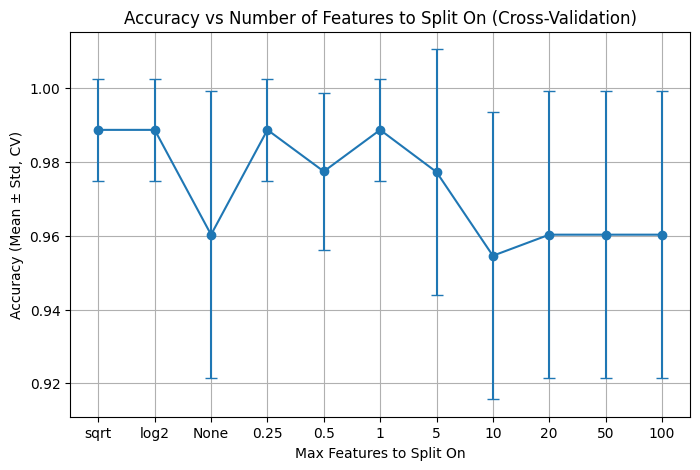

In [100]:
# wine experiment for max_features
wine_maxfeat_metrics, wine_maxfeat_filename = run_max_features_experiment(
    X_wine_scaled, y_wine,
    dataset_name='wine'
)

plot_max_features_vs_accuracy(wine_maxfeat_filename)

Max Features: sqrt, Accuracy: 0.848 ± 0.005, F1: 0.844 ± 0.004
Max Features: log2, Accuracy: 0.845 ± 0.004, F1: 0.840 ± 0.003
Max Features: None, Accuracy: 0.851 ± 0.005, F1: 0.846 ± 0.005
Max Features: 0.25, Accuracy: 0.850 ± 0.006, F1: 0.846 ± 0.006
Max Features: 0.5, Accuracy: 0.852 ± 0.008, F1: 0.847 ± 0.008
Max Features: 1, Accuracy: 0.835 ± 0.005, F1: 0.829 ± 0.005
Max Features: 5, Accuracy: 0.842 ± 0.006, F1: 0.837 ± 0.006
Max Features: 10, Accuracy: 0.848 ± 0.005, F1: 0.844 ± 0.004
Max Features: 20, Accuracy: 0.849 ± 0.007, F1: 0.845 ± 0.007
Max Features: 50, Accuracy: 0.851 ± 0.006, F1: 0.846 ± 0.006
Max Features: 100, Accuracy: 0.849 ± 0.005, F1: 0.844 ± 0.004
Metrics saved to experiment_3/rf_max_features_cv_metrics__adult_income__20251018-180615.json


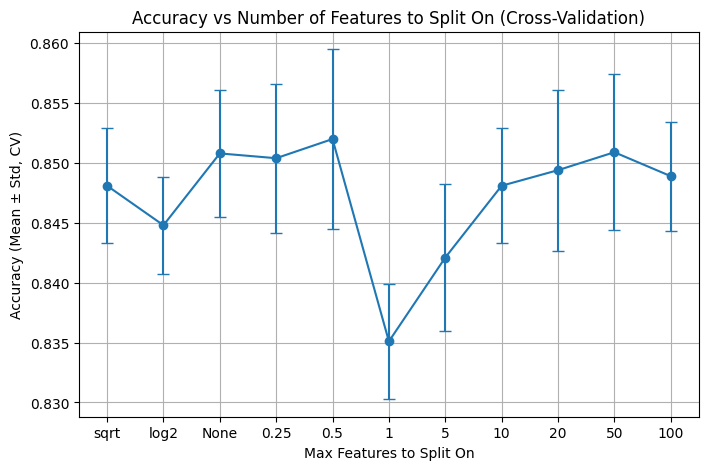

In [101]:
# Adult Income experiment
adult_maxfeat_metrics, adult_maxfeat_filename = run_max_features_experiment(
    X_adult_processed, adult_target,
    dataset_name='adult_income'
)

plot_max_features_vs_accuracy(adult_maxfeat_filename)

## Experiment 4

Full parameter exploration

- Vary tree depths and number of features per split simultaneously.

Results: heatmap or 3D surface plot (accuracy as function of depth and features).

## Visualisations & Metrics